<h1 align="center"> Campus Recruitment </h1>

![Recruitment](https://cdn.pixabay.com/photo/2017/08/05/17/16/business-2584713_960_720.jpg)
Kaggle Dataset from Ben Roshan D: <br></br>
[Source (Accessed 2020-05-21)](https://www.kaggle.com/benroshan/factors-affecting-campus-placement)

<br></br>
<br></br>

Main fields of interest:
- How do the student's degree results impact placement outcomes?
- How does the MBA Specialisation impact the attractivity for employers?
- What other assumptions can be made?
- Can we reliably predict student placement outcome to better support students, who would not get one?

## Index

<div class="alert alert-block alert-info">

### 1. [Visualizations](#Visualizations)<br>
   - [Degree Percentages and Recruitment Outcome](#Degree-Percentages-and-Recruitment-Outcome)<br>
   - [Outcome per Specialisation](#Outcome-per-Specialisation)<br>
   - [Salary Comparison of Successful Applicants](#Salary-Comparison-of-Successful-Applicants)<br>
   
### 2. [Additional Assumptions](#Additional-Assumptions:)<br>
   - [Undergraduate Degree/Placement-Density](#Undergraduate-Degree/Placement-Density)<br>
   - [Work Experience <-> Placement](#Work-Experience-<->-Placement)<br>
   - [Gender <-> Placement](#Gender-<->-Placement)<br>
   
### 3. [Predictive Model](#Predictive-Model)<br>
   - [Preparing Data and Getting Insight](#Preparing-Data-and-Getting-Insight)<br>
   - [Building Model](#Building-Model)<br>
</div>

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('benroshan/factors-affecting-campus-placement', unzip=True)

### Reading Data into DataFrame

In [1]:
import pandas as pd

placement_df = pd.read_csv("Placement_Data_Full_Class.csv")
placement_df.drop("sl_no", axis = 1, inplace= True)
print(placement_df.info())
print(placement_df.describe())
placement_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    object 
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  status          215 non-null    object 
 13  salary          148 non-null    float64
dtypes: float64(6), object(8)
memory usage: 23.6+ KB
None
            ssc_p       hsc_p    degree_p     etest_p       mba_p  \
count  215.000000  215.000000  215.000000  215.0

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


## Visualizations

### Degree Percentages and Recruitment Outcome

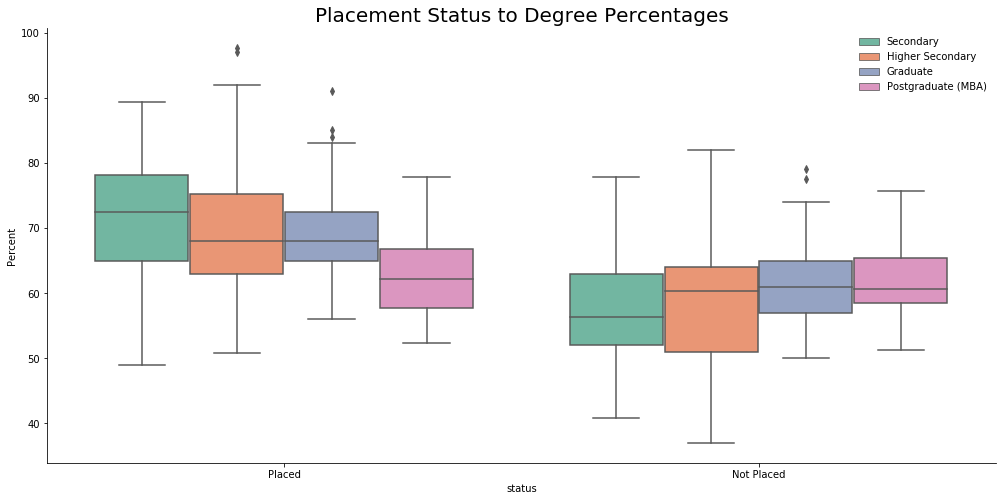

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

def remove_spines_partial(axes):
    for spine in ["top", "right"]:
        axes.spines[spine].set_visible(False)

pct_df = placement_df.copy()
cols = ["ssc_p", "hsc_p", "degree_p", "mba_p"]
pct_df = pct_df[cols + ["status"]]
pct_df = pd.melt(pct_df,id_vars = ["status"], value_vars = cols)

pct_df.rename(columns={"value": "Percent"}, inplace = True)
pct_df["variable"].replace(to_replace=cols, value=["Secondary", "Higher Secondary", "Graduate", "Postgraduate (MBA)"], inplace = True)

plt.figure(figsize=(17,8))
pcts = sns.boxplot(x = "status", y= "Percent", hue = "variable", data = pct_df, palette = "Set2")

remove_spines_partial(pcts)

pcts.legend(frameon=False)
pcts.set_title("Placement Status to Degree Percentages", fontsize=20);

### Outcome per Specialisation

Text(0.5, 1.0, 'Placement Outcome per MBA Specialisation')

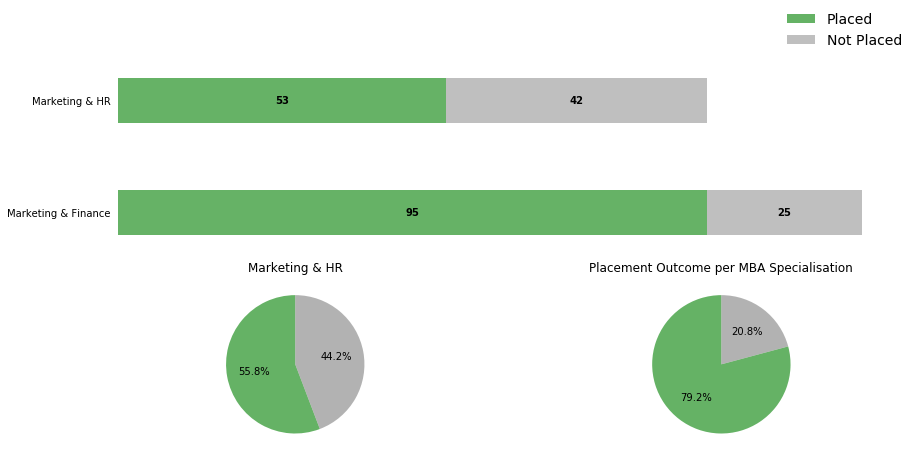

In [3]:
def bar_labels(bars, axes):
    # Taking bar artists and axes object and creates labels relating to the values
    for bar in bars:
        axes.text(bar.get_x() + bar.get_width()/2, bar.get_y()+bar.get_height()/2,
                  bar.get_width(), fontsize = 10, fontweight="bold",
                  color = "black", ha = "center", va = "center")

def remove_spines(axes):
    #Removing spines of a given axes object
    for spine in axes.spines.values():
        spine.set_visible(False)

def wedge_alpha(wedges):
    for i in range(len(wedges[0])):
        wedges[0][i].set_alpha(0.6)

#Copying Df
major_df = placement_df.loc[:,["status", "specialisation", "salary"]].copy()
placed = major_df[major_df["status"] == "Placed"].groupby("specialisation").count()
not_placed = major_df[major_df["status"] == "Not Placed"].groupby("specialisation").count()

#Creating gridspec
fig = plt.figure(figsize=(14,7))
spec = mpl.gridspec.GridSpec(2,2, figure = fig)

#Creating first Chart - Barchart with Placed/unplaced per specialisation
num = plt.subplot(spec[0,:])
bars_placed = num.barh(placed.index, placed["status"],height=0.4, color = "green", alpha = 0.6)
bars_not_placed = num.barh(not_placed.index, not_placed["status"],left=placed["status"], 
                           height = 0.4, color = "grey", alpha = 0.5)
plt.tick_params(bottom = False,
               labelbottom = False,
               left = False)
num.set_yticklabels(["Marketing & Finance", "Marketing & HR"])

remove_spines(num)

bar_labels(bars_placed, num)
bar_labels(bars_not_placed, num)
num.legend(labels=["Placed", "Not Placed"], frameon = False, loc=(0.85,1.1), prop={'size': 14})

#Creating two piecharts for percentages
major_df["count"] = 1
students = major_df.groupby(["specialisation", "status"]).count()

#HR
pie_hr = plt.subplot(spec[1,0])
pie_hr.set_title("Marketing & HR")
placed_hr_students = students.loc[("Mkt&HR", "Placed"),"count"]
not_placed_hr_students = students.loc[("Mkt&HR", "Not Placed"),"count"]
wedges_hr = pie_hr.pie([placed_hr_students, not_placed_hr_students], colors=["green", "grey"], 
                       startangle = 90, autopct="%1.1f%%")
wedge_alpha(wedges_hr)

#Finance
pie_fin = plt.subplot(spec[1,1])
pie_fin.set_title("Marketing & Finance")
placed_fin_students = students.loc[("Mkt&Fin", "Placed"),"count"]
not_placed_fin_students = students.loc[("Mkt&Fin", "Not Placed"),"count"]
wedges_fin = pie_fin.pie([placed_fin_students, not_placed_fin_students], colors=["green", "grey"], 
                         startangle = 90, autopct="%1.1f%%")
wedge_alpha(wedges_fin)
plt.title("Placement Outcome per MBA Specialisation")

### Salary Comparison of Successful Applicants

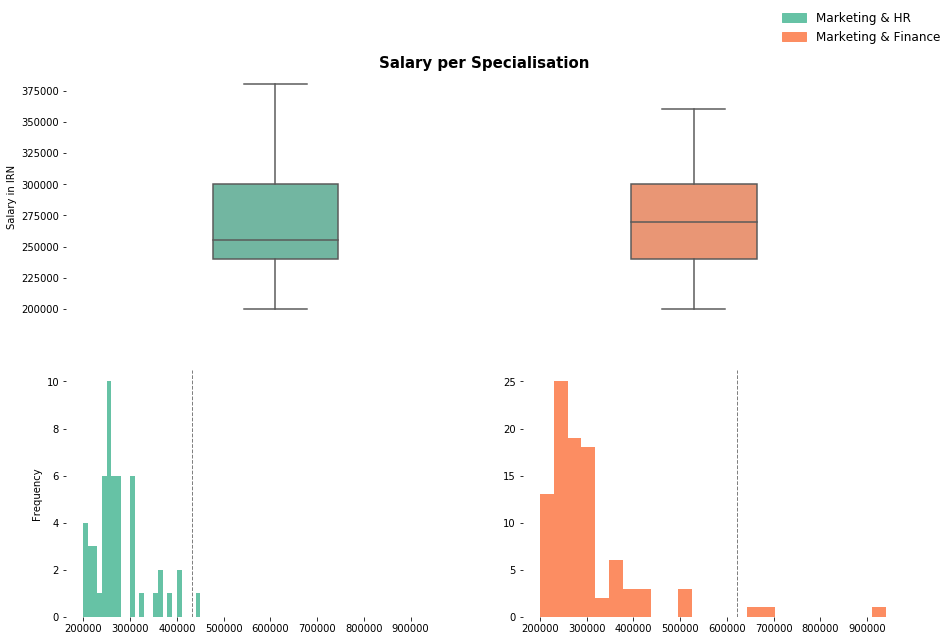

In [4]:
def spec_hist(pos, specialisation):
    temp_df = major_df["salary"][major_df["specialisation"] == specialisation].to_frame()
    mu = temp_df.values.mean()
    sd = temp_df.values.std()
    li = mu + 3*sd
    
    if pos == 0:
        plt.subplot(spec2[1,pos])
    else:
        plt.subplot(spec2[1,pos], sharex = hist_hr)
    plt.hist(temp_df["salary"], bins = 25, color = palette[pos], linewidth=10)
    plt.axvline(li, color='grey', linestyle='dashed', linewidth=1)
    remove_spines(plt.gca())
    
    return plt.gca()

major_df = major_df[["specialisation", "salary"]].dropna()
fig2 = plt.figure(figsize=(15,10))

spec2 = mpl.gridspec.GridSpec(2,2, figure = fig2)

#Create Main Boxplot
plt.subplot(spec2[0,0:])
sns.boxplot(x = "specialisation", y = "salary", data = major_df, showfliers = False, palette = "Set2", width = 0.3)
remove_spines(plt.gca())
plt.gca().set_xticklabels(["Marketing & HR", "Marketing & Finance"])
plt.title("Salary per Specialisation", fontsize=15, fontweight="bold")
plt.xlabel(None)
plt.ylabel("Salary in IRN")
plt.tick_params(axis = "x",
               labelbottom = False,
               bottom = False)

#Create Legend
palette = sns.color_palette(palette="Set2")
hr_leg = mpl.patches.Patch(color=palette[0], label="Marketing & HR")
fin_leg = mpl.patches.Patch(color=palette[1], label="Marketing & Finance")
plt.legend(handles=[hr_leg, fin_leg], frameon = False, loc=(0.85,1.1), prop={'size': 12})


#Create histograms
hist_hr = spec_hist(0, "Mkt&HR")
hist_fin = spec_hist(1, "Mkt&Fin")
hist_hr.set_ylabel("Frequency");

#### Key Take-Away
Those students with a finance MBA specialisation are archieving better placement outcomes and better salaries. The amount of outliers, who are earning uncommonly much is also higher for those majoring in finance.

## Additional Assumptions:

- Students with an Undergraduate Degree in Science & Technology perform better than students in the other two faculties
- Students with work experience are more successful in securing a placement position
- Male students have a small advantage over female students

### Undergraduate Degree/Placement-Density

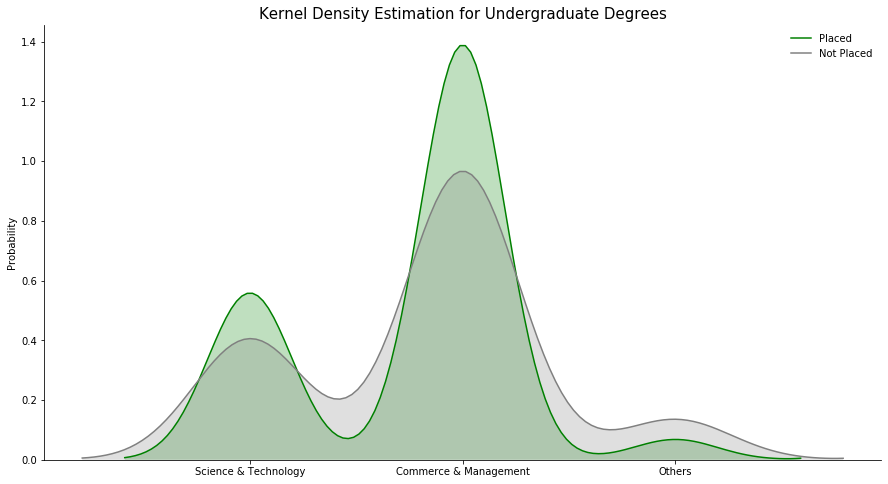

In [5]:
fig3 = plt.figure(figsize=(15,8))
ug_df = placement_df[["degree_t","status"]].copy()
ug_df["degree_t"].replace(to_replace = ["Sci&Tech", "Comm&Mgmt", "Others"], value = range(3), inplace = True)

ug_spec = sns.kdeplot(ug_df["degree_t"][ug_df.status == "Placed"],
                     color = "g",
                     label = "Placed",
                     shade = True)
ug_spec = sns.kdeplot(ug_df["degree_t"][ug_df.status == "Not Placed"],
                     color = "grey",
                     label = "Not Placed",
                     shade = True)
ug_spec.set_title("Kernel Density Estimation for Undergraduate Degrees", fontsize=15)
ug_spec.set_xticks([0,1,2])
ug_spec.set_xticklabels(["Science & Technology", "Commerce & Management", "Others"])
ug_spec.set_ylabel("Probability")
ug_spec.legend(frameon=False)



remove_spines_partial(ug_spec)

##### Key Take-Away
Even Though many more students have undergraduate degrees in Commerce & Management, they actually outperform the Science & Tech degrees. It's also surprising, that students holding a degree from a different faculty and are archieving a placement are in the minority compared to those faculty peers wo are not landing a placement.

### Work Experience <-> Placement

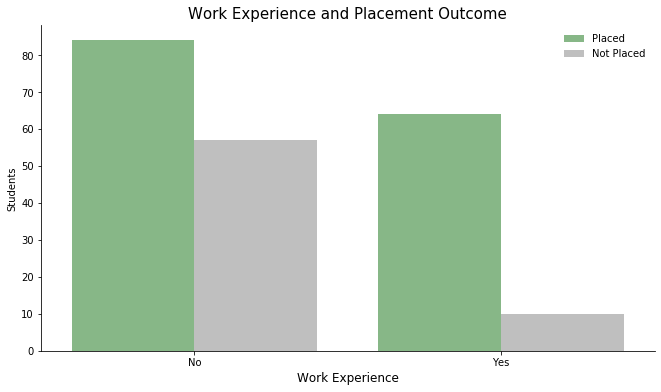

In [6]:
import numpy as np

def create_countplot(criteria):
    colors = {"Placed":"green","Not Placed":"grey"}
    ax = sns.countplot(x = criteria, hue = "status", data = placement_df, palette=colors, alpha = 0.5)
    plt.legend(frameon=False)
    remove_spines_partial(plt.gca())
    return ax

def create_percent_barplot(criteria):
    # Taking in Plot Criteria and returning stacked barchart with placement outcome
    temp_df = placement_df.groupby([criteria, "status"]).count().reset_index()
    temp_df = pd.pivot_table(temp_df, values = "specialisation", index = "status", columns = criteria)
    if criteria == "gender":
        temp_df = temp_df[temp_df.columns[::-1]]
    total = np.asarray([first + second for first, second in zip(temp_df.iloc[0,:], temp_df.iloc[1,:])])
    not_placed = np.asarray([temp_df.iloc[0,0], temp_df.iloc[0,1]])/total*100
    placed = np.asarray([temp_df.iloc[1,0], temp_df.iloc[1,1]])/total*100
    
    ax = plt.bar(temp_df.columns, placed, color = "g", alpha = 0.5, label = "Placed", width = 0.7)
    ax = plt.bar(temp_df.columns, not_placed, bottom = placed, color = "grey", alpha = 0.5, label = "Not Placed"
                , width = 0.7)
    plt.ylabel("Percent")
    plt.legend(frameon= False, loc =(1.005,1.005))
    remove_spines_partial(plt.gca())
    return plt.gca()


fig5 = plt.figure(figsize=(11,6))
we = create_countplot("workex")

we.set_title("Work Experience and Placement Outcome", fontsize=15)
we.set_xlabel("Work Experience", fontsize=12)
we.set_ylabel("Students");


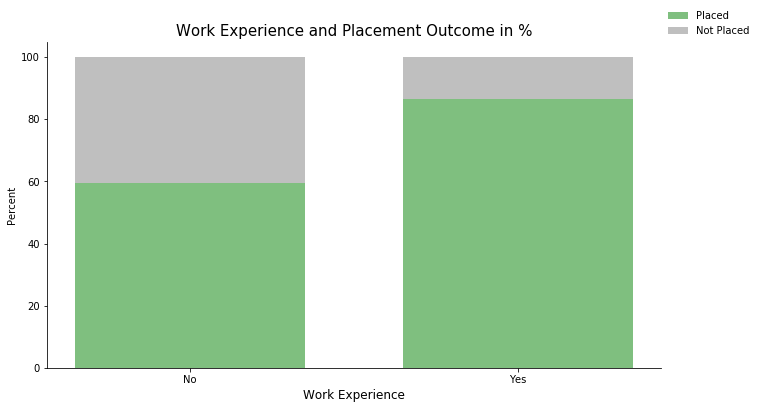

In [7]:
fig8 = plt.figure(figsize=(11,6))
we_pct = create_percent_barplot("workex")
we_pct.set_title("Work Experience and Placement Outcome in %", fontsize = 15)
we_pct.set_xlabel("Work Experience", fontsize = 12)
we_pct.set_xticklabels(["No","Yes"]);

#### Key Take-Away
The majority of the course have not got any work experience. As expected, those students with work experience have got a significant advantage.

### Gender <-> Placement

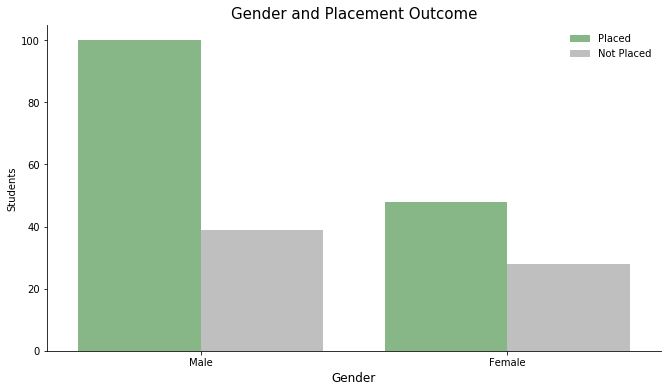

In [8]:
fig6 = plt.figure(figsize=(11,6))

gender = create_countplot("gender")

gender.set_title("Gender and Placement Outcome", fontsize=15)
gender.set_xlabel("Gender", fontsize = 12)
gender.set_xticklabels(["Male", "Female"])
gender.set_ylabel("Students");


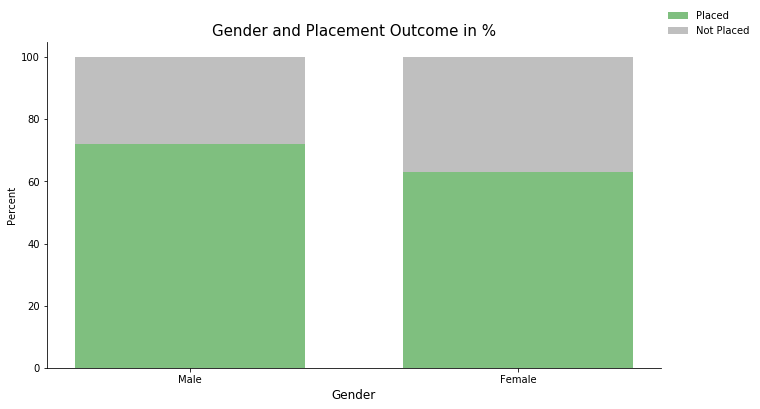

In [9]:
fig9 = plt.figure(figsize=(11,6))
gender_pct = create_percent_barplot("gender")
gender_pct.set_title("Gender and Placement Outcome in %", fontsize = 15)
gender_pct.set_xlabel("Gender", fontsize = 12)
gender_pct.set_xticklabels(["Male","Female"]);

#### Key Take-Away
Roughly 2/3 of the course are male and 1/3 are female. However, the male graduates seem not only slightly, but actually quite a bit more sucessful in finding a placement. They are more than 10% ahead.

# Predictive Model

### Preparing Data and Getting Insight

Creating "Career Consistency" as new feature. If a student always had a major in Commerce/Science, they have a consistent career. \
Creating is_talent feature, that will result as true, if the person was in the 75%-quantile of their undergraduate degree grade and mba grade.

In [10]:
# Consistency
comm_career = (placement_df["hsc_s"] == "Commerce") & (placement_df["degree_t"] == "Comm&Mgmt")
sci_career = (placement_df["hsc_s"] == "Science") & (placement_df["degree_t"] == "Sci&Tech")
placement_df.insert(len(placement_df.columns) - 2, "consistency",np.where((comm_career) | (sci_career), 1, 0))

# Talent
degree_p_90 = placement_df["degree_p"] >= placement_df["degree_p"].quantile(0.75)
mba_p_90 = placement_df["mba_p"] >= placement_df["mba_p"].quantile(0.75)

placement_df.insert(len(placement_df.columns) - 2, "is_talent",np.where((degree_p_90) & (mba_p_90), 1, 0))

- Encoding categorical features 
- Droping features, that might cause data leakage

Reason for dropping the employablility test:
This test will likely be available at a time, where we already want measurements to be active. The test will likely be available at a later stage and there most likely also is no option to use predicted scores as it would be possible for degree grades.

In [11]:
from sklearn.preprocessing import LabelEncoder
# Encoding Features
le = LabelEncoder()
cols = ["gender", "ssc_b", "hsc_b", "hsc_s", "degree_t", "workex", "specialisation", "status"]
placement_df[cols] = placement_df[cols].apply(le.fit_transform)

# Drop cells that would cause data leak
placement_df.drop(["etest_p", "salary"], axis = 1, inplace = True)

placement_df

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,specialisation,mba_p,consistency,is_talent,status
0,1,67.00,1,91.00,1,1,58.00,2,0,1,58.80,0,0,1
1,1,79.33,0,78.33,1,2,77.48,2,1,0,66.28,1,1,1
2,1,65.00,0,68.00,0,0,64.00,0,0,0,57.80,0,0,1
3,1,56.00,0,52.00,0,2,52.00,2,0,1,59.43,1,0,0
4,1,85.80,0,73.60,0,1,73.30,0,0,0,55.50,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,1,80.60,1,82.00,1,1,77.60,0,0,0,74.49,1,1,1
211,1,58.00,1,60.00,1,2,72.00,2,0,0,53.62,1,0,1
212,1,67.00,1,67.00,1,1,73.00,0,1,0,69.72,1,1,1
213,0,74.00,1,66.00,1,1,58.00,0,0,1,60.23,1,0,1


In [12]:
placement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    int64  
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    int64  
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    int64  
 5   hsc_s           215 non-null    int64  
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    int64  
 8   workex          215 non-null    int64  
 9   specialisation  215 non-null    int64  
 10  mba_p           215 non-null    float64
 11  consistency     215 non-null    int64  
 12  is_talent       215 non-null    int64  
 13  status          215 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 23.6 KB


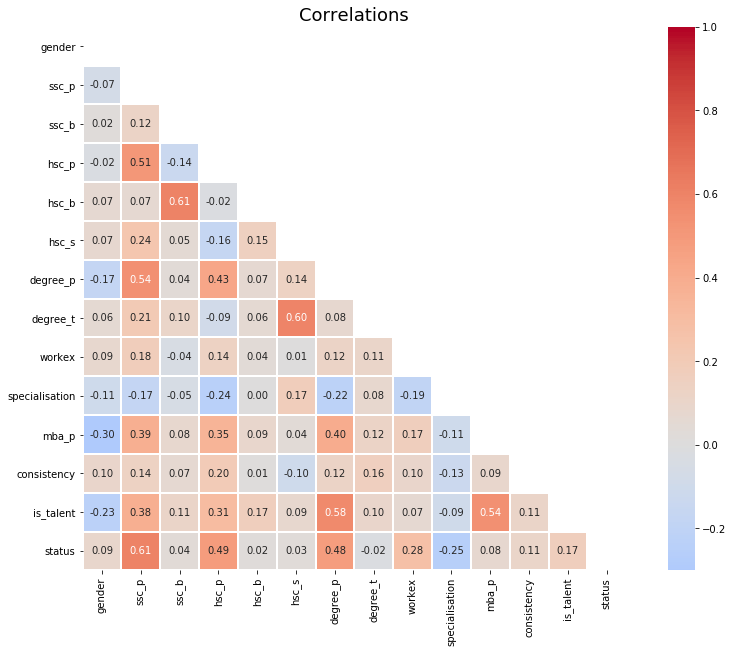

In [13]:
mask = np.zeros_like(placement_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (15,10))
sns.heatmap(placement_df.corr(), 
            annot=True,
            mask = mask,
            cmap = "coolwarm",
            linewidths = 1, 
            linecolor= "w",
            center = 0,
            fmt=".2f",
            square=True)
plt.title("Correlations",fontsize = 18);

In [14]:
import scipy

print("p-values")
for feature in placement_df.columns:
    print("{}: {:.5f}".format(feature, scipy.stats.pearsonr(placement_df[feature], placement_df["status"])[1]))

p-values
gender: 0.18535
ssc_p: 0.00000
ssc_b: 0.58653
hsc_p: 0.00000
hsc_b: 0.80489
hsc_s: 0.62581
degree_p: 0.00000
degree_t: 0.76669
workex: 0.00004
specialisation: 0.00020
mba_p: 0.26145
consistency: 0.12469
is_talent: 0.01211
status: 0.00000


#### Most Important Feautures

- Secondary Education Grade (ssc_p): 0.61
- Higher Secondary School Grade (hsc_p): 0.49
- Undergraduate Degree Grade (degree_p): 0.48
- Work Experience: 0.28
- MBA Specialisation: - 0.25

In [15]:
from sklearn.preprocessing import StandardScaler
X = placement_df.iloc[:,:-1]
y = placement_df.iloc[:,-1]

scaler = StandardScaler()
X = scaler.fit_transform(X)
len(X)

215

## Building Model

#### General Objective
The main target is to find a placement for every student, while the cost of the measurements shouldn't explode. Therefore, it is the most suitable approach to use the area under curve in order to measure the effectiveness of the model.

##### Dummy Classifier

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

params = {"strategy" : ["stratified", "most_frequent", "uniform"]}
dummy_clf = GridSearchCV(DummyClassifier(), params, cv = 10, scoring = "roc_auc").fit(X,y)

##### KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier
k = range(1,25)
params = {"n_neighbors" : k}
knn_clf = GridSearchCV(KNeighborsClassifier(), params, cv = 10, scoring = "roc_auc").fit(X,y)

##### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
C = np.linspace(0.001,10,15)
params = {"C" : C}
lr_clf = GridSearchCV(LogisticRegression(), params, cv = 10, scoring = "roc_auc").fit(X,y)

##### SVM

In [19]:
from sklearn.svm import SVC

C = np.linspace(0.001,10,15)
gammas = np.linspace(0.001,10,15)
params = {"C" : C, "gamma" : gammas}
svm_clf = GridSearchCV(SVC(), params, cv = 10, scoring = "roc_auc").fit(X,y)

##### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
n_est = range(100,151,10)
max_depth = range(2,10)


params = {"n_estimators": n_est, "max_depth" : max_depth}

rf_clf = GridSearchCV(RandomForestClassifier(), params, cv = 10, scoring = "roc_auc").fit(X,y)

### Classifier Comparison

In [21]:
clfs = {"Dummy" :dummy_clf, "K Nearest Neighbors" : knn_clf, "Logistic Regression" : lr_clf, "Support Vector Machine" : svm_clf, 
        "Random Forest" : rf_clf}
results = {}

for name, clf in clfs.items():
    score = np.mean(clf.cv_results_["mean_test_score"])
    results[name] = score

results = pd.DataFrame(index = results,data = results.values(), columns = ["AUC Score"])
results.sort_values("AUC Score", ascending = False)

,AUC Score
Logistic Regression,0.930314
Random Forest,0.922154
K Nearest Neighbors,0.863446
Support Vector Machine,0.789295
Dummy,0.495873


In [22]:

features = [(criteria, lr_weight, rf_weigth) for criteria, lr_weight, rf_weigth in 
            zip(
                placement_df.columns[:-1],
                map(lambda x: abs(x),lr_clf.best_estimator_.coef_[0]), 
                map(lambda x: abs(x),rf_clf.best_estimator_.feature_importances_)
                )
            ]
weighting = pd.DataFrame(features, columns = ["Feature", "Weight LR (in %)", "Weight RF (in %)"]).set_index("Feature")
weighting["Weight LR (in %)"] = weighting["Weight LR (in %)"].apply(lambda x: (x / weighting["Weight LR (in %)"].sum()) * 100)
weighting["Weight RF (in %)"] = weighting["Weight RF (in %)"].apply(lambda x: (x / weighting["Weight RF (in %)"].sum()) * 100)
weighting.sort_values("Weight LR (in %)", ascending = False)

,Weight LR (in %),Weight RF (in %)
Feature,,
ssc_p,26.405556,27.275516
degree_p,15.744465,19.461266
hsc_p,12.453498,21.176003
mba_p,12.262979,13.495983
workex,11.463032,4.197834
degree_t,6.378866,1.986186
gender,5.667329,2.395831
is_talent,4.451199,1.018553
ssc_b,1.883999,1.713921
